# Text Classification Project

In [5]:
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
import string

In [6]:
datasett = fetch_20newsgroups() #importing dataset directly from sklearn instead of downloading and uploading it
stopWords = set(stopwords.words('english')) #importing stopwords from nltk
stopWords.update(list(string.punctuation)) #adding punctuations to the list as they are also stopwords
more_words = np.loadtxt("stop_words_english.txt",dtype = str ,delimiter = " ") #found more stop words on web adding that also
stopWords.update(more_words)

In [7]:
x = datasett.data
y = datasett.target
x_modified = [word_tokenize(i) for i in x]
#x_modified is set of words after tokenization
Xtrain,Xtest,Ytrain,Ytest = train_test_split(x_modified,y,random_state = 1)
#spliting the data into xtrain,xtest,ytrain,ytest

In [8]:
useful_words = []
for current in Xtrain:
    for word in current:
        if (word.lower() not in stopWords) and (len(word) != 1) and (len(word) != 2) and (word[0]!="'") and (word!="n't") and (word[0]!="."):
            useful_words.append(word)
#this will store only usefull words in the list (neglecting stopwords)

In [10]:
#this function is making a dictionary which is maintaining the freq of each word
def freq_dict(Words):
    dic = dict()
    for word in Words: #interating each word
        if word in dic.keys(): #if it is presnt
            dic[word]+=1
        else: #if not present
            dic[word] = 1
    return dic
dic = freq_dict(useful_words) 

In [12]:
#now maintaining two different numpy arrays one for freq and one for words .. they will be sorted in decreasing order
#further with respect the freq array
freq = np.array([i for i in dic.values()])
words = np.array([i for i in dic.keys()])
freq = np.sort(freq)[::-1]
words = words[np.argsort(freq)][::-1]
# here we are firstly sorting the numpy array then reversing it for making it in decreasing fashion

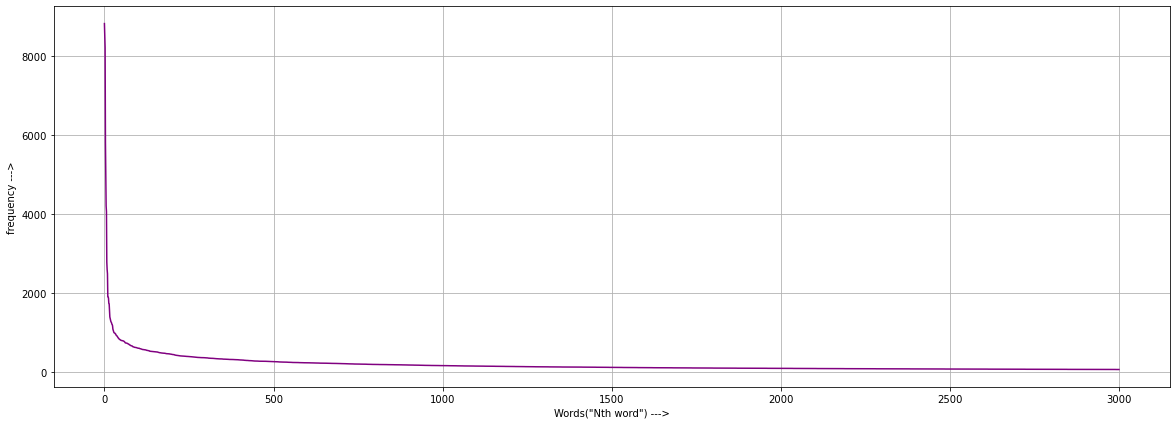

In [21]:
import matplotlib.pyplot as plt
low = 0 #lower limit
high = 3000 #upper limit
Difference = 50 #difference between each xtick
plt.figure(figsize=(20,7)) # adjusting figure size
#ploting the graph
plt.plot(np.arange(len(freq))[low:high] , freq[low:high], color = "purple")
#labeling the graph
plt.xlabel('Words("Nth word") --->')
plt.ylabel('frequency --->')
plt.grid()
plt.show()

In [32]:
#this function is the main working of Tect classification it will make a 2d array with data and features adn it will store occurence of every word at respective indexes 
def data_modifier(X_data,features):
    #making a numpy array with all zeroes of size X_data, features length .. (2D)
    modified_data = np.zeros((len(X_data),len(features)))
    for i in range(len(X_data)): 
        current = X_data[i]
        d = dict() #for maintaining the freq of every word
        for word in current:
            if word in d.keys():
                d[word]+=1
            else:
                d[word]=1
        for j in range(len(features)):
            if features[j] in d.keys():
                modified_data[i][j] = d[features[j]] #updating freq of each word present in current data 
    return modified_data

In [33]:
features=words[20:100000] # we are picking up top frequency words which are really usefull for classification
x_train_modified = data_modifier(Xtrain, features)

In [35]:
x_test_modified= data_modifier(Xtest, features)

# Trying out Sklearn's multinomial classifier

In [38]:
clf = MultinomialNB()
clf.fit(x_train_modified,Ytrain)
clf.score(x_test_modified,Ytest)

0.8798161894662425

Note: the score from SKlearn's inbuilt multinomial classifier is coming to be 0.8798161894662425

# Creating our own classifier

In [45]:
import math
def fit(x_train,y_train): #this function will make the dictionary which will maintain freq of words w.r.t current class or current word
    count = dict() #creating dictionary
    for i in range(20): #we have total 20 newsgroups in the data
        currentdoc = x_train[y_train == i] #ith newsgroup in xtrain
        count[i] = dict()
        count[i]["Total"] = 0 #total words in this newsgroup
        for j in range(len(features)):
            count[i][features[j]] = currentdoc[:,j].sum()#total words in current feature
            count[i]["Total"] += count[i][features[j]] 
    return count


def probability(dictionary,x,current_class):
    prob_for_each_word = [] # we will maintain a list which will maintain prob for each word and at the end we will return its sum
    for i in range(len(x)):
        if x[i]!=0:
            numerator = dictionary[current_class][features[i]]
            dino = dictionary[current_class]["Total"]
            prob = math.log(numerator + 1)- math.log(dino + len(x)) #as in log calculation log a - log b = log(a/b)
            prob_for_each_word.append(prob)
    return sum(prob_for_each_word)


def predict_single(dictionary,x):
    classes = dictionary.keys() #words
    best_prob = -1000 #probability cant be negative
    best_class = -1 #word with top probability
    first_run = True #always update in first run
    for current_class in classes: 
        #iterating each word
        prob_current = probability(dictionary,x,current_class) #calculating probability
        
        if (first_run or prob_current > best_prob): #updating if firstrun or better
            best_prob = prob_current
            best_class = current_class
        first_run = False
    return best_class #returning best class


def predict(x_test,dictionary):
    y_pred = [] #list for y predict
    
    for x in x_test: #iterating x test
        y_pred.append(predict_single(dictionary,x)) #for each x predicting the best possible newsletter
        
    return y_pred #returning Y predict

In [46]:
dictionary = fit(x_train_modified,Ytrain) 
Y_pred = predict(x_test_modified,dictionary) 

In [52]:
from sklearn.metrics import confusion_matrix #printing confusion matrix
for i in confusion_matrix(y_true=Ytest, y_pred=Y_pred):
    for j in i:
        print(j, end="    ")
    print()

103    0    0    0    0    0    0    0    0    0    0    0    0    0    0    5    0    3    0    3    
0    112    1    6    2    19    1    0    0    0    0    6    0    1    2    1    0    0    1    0    
0    3    84    10    1    34    0    1    0    0    0    6    0    0    0    0    0    0    0    0    
1    3    1    120    5    7    3    0    0    0    0    7    3    0    0    1    0    1    0    0    
0    2    0    2    122    2    2    0    0    1    0    4    0    1    0    0    0    0    2    0    
0    1    0    0    2    147    0    0    0    0    0    0    0    1    0    0    0    0    2    0    
0    3    0    8    4    2    87    3    1    2    4    7    11    1    3    1    3    4    3    0    
0    0    0    1    0    0    3    118    1    0    1    0    3    0    2    1    2    1    4    0    
0    0    0    0    0    0    3    0    124    0    0    0    0    0    0    0    3    1    0    0    
0    1    0    0    0    0    0    0    0    125    3    0    0    1   

In [53]:
from sklearn.metrics import classification_report
#printing the classification report for our own naive bayes classifier.
print(classification_report(y_true=Ytest, y_pred=Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       114
           1       0.84      0.74      0.79       152
           2       0.98      0.60      0.75       139
           3       0.77      0.79      0.78       152
           4       0.88      0.88      0.88       138
           5       0.67      0.96      0.79       153
           6       0.86      0.59      0.70       147
           7       0.94      0.86      0.90       137
           8       0.98      0.95      0.96       131
           9       0.95      0.93      0.94       135
          10       0.94      0.98      0.96       136
          11       0.78      1.00      0.87       145
          12       0.88      0.76      0.81       157
          13       0.96      0.96      0.96       151
          14       0.90      0.96      0.93       155
          15       0.82      0.96      0.88       159
          16       0.88      0.97      0.92       140
          17       0.82    

# Observations


Note: Accuracy for both the algorithms are almost same the inbuilt algorithm is showing 0.87 and our own algorithm is showing 0.86